In [ ]:
import keras
from keras import layers
from keras import backend
from keras import models
import numpy as np
from tensorflow.python.framework.ops import disable_eager_execution
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
disable_eager_execution()

In [ ]:
class CustomVariationalLayer(keras.layers.Layer):
    def __init__(self, z_mean, z_log_var):
        super().__init__()
        self.z_mean = z_mean
        self.z_log_var = z_log_var

    def vae_loss(self, x, z_decoded):
        x = backend.flatten(x)
        z_decoded = backend.flatten(z_decoded)

        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        k1_loss = -5e-4 * backend.mean(1 + self.z_log_var - backend.square(self.z_mean) - backend.exp(self.z_log_var), axis=-1)
        return backend.mean(xent_loss + k1_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

class VAE():
    def __init__(self, img_shape, latent_dim):
        self.img_shape = img_shape
        self.latent_dim = latent_dim

        self._model()

    def _sampling(self, args):
        z_mean, z_log_var = args
        epsilon = backend.random_normal(shape=(backend.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + backend.exp(z_log_var) * epsilon

    def _model(self):
        input_img = keras.Input(shape=self.img_shape)

        x = layers.Conv2D(32, 3, padding="same", activation="relu")(input_img)
        x = layers.Conv2D(64, 3, padding="same", activation="relu", strides=(2, 2))(x)
        x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)

        shape_before_flattening = backend.int_shape(x)

        x = layers.Flatten()(x)
        x = layers.Dense(32, activation="relu")(x)

        z_mean = layers.Dense(self.latent_dim)(x)
        z_log_var = layers.Dense(self.latent_dim)(x)

        z = layers.Lambda(self._sampling)([z_mean, z_log_var])

        decoder_input = layers.Input(backend.int_shape(z)[1:])

        x = layers.Dense(np.prod(shape_before_flattening[1:]), activation="relu")(decoder_input)
        x = layers.Reshape(shape_before_flattening[1:])(x)
        x = layers.Conv2DTranspose(32, 3, padding="same", activation="relu", strides=(2, 2))(x)
        x = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)

        self.decoder = models.Model(decoder_input, x)
        z_decoded = self.decoder(z)

        self.y = CustomVariationalLayer(z_mean, z_log_var)([input_img, z_decoded])

        self.vae = models.Model(input_img, self.y)
        
        self.vae.compile(optimizer="adam", loss=None)

    def train(self, **kwargs):
        self.vae.fit(**kwargs)

    def save(self, filename):
        self.decoder.save(filename)

    def load(self, filename):
        self.decoder = keras.models.load_model(filename)

    def produce_result(self, z_sample, print=False):
        z_sample = np.array([z_sample])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = self.decoder.predict(z_sample, batch_size=batch_size, verbose=0)
        digit = x_decoded[0].reshape(28, 28) # MNIST Image Size

        if print:
            plt.imshow(digit, cmap="binary")

        return digit

In [ ]:
from keras.datasets import mnist

(Xtrain, _), (Xtest, _) = mnist.load_data()

Xtrain = Xtrain.astype('float32') / 255.
Xtrain = Xtrain.reshape(Xtrain.shape + (1,))
Xtest = Xtest.astype('float32') / 255.
Xtest = Xtest.reshape(Xtest.shape + (1,))

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

model = VAE(img_shape, latent_dim)

model.train(x=Xtrain, y=None, shuffle=True, epochs=5, batch_size=batch_size, validation_data=(Xtest, None))
model.save("mnist_vae.model")

In [ ]:
model = VAE(img_shape, latent_dim)
model.load("mnist_vae.model")

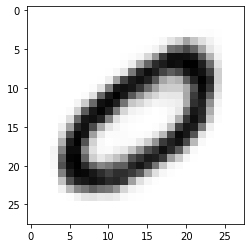

In [58]:
digit = model.produce_result([-1.5, -1.5], print=True) # Generate Digit